In [18]:
%load_ext legate.jupyter
%legate_info

The legate.jupyter extension is already loaded. To reload it, use:
  %reload_ext legate.jupyter
Kernel 'legate_1gpu' configured for 1 node(s)

Cores:
  CPUs to use per rank : 4
  GPUs to use per rank : 1
  OpenMP groups to use per rank : 0
  Threads per OpenMP group : 4
  Utility processors per rank : 2

Memory:
  DRAM memory per rank (in MBs) : 4000
  DRAM memory per NUMA domain per rank (in MBs) : 0
  Framebuffer memory per GPU (in MBs) : 4000
  Zero-copy memory per rank (in MBs) : 32
  Registered CPU-side pinned memory per rank (in MBs) : 0



In [19]:
import legateboost as lb
import numpy as np
import cunumeric as cn
import xgboost as xgb

from sklearn.datasets import fetch_covtype
X,y = fetch_covtype(return_X_y=True)
y = y - 1 # labels start at 1 in the dataset

# Split into train and test
train_size = 0.8
rs = cn.random.RandomState(37)
train = rs.binomial(1, 0.8, size=y.shape[0]).astype(bool)
X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

n_estimators = 100
max_depth = 6
learning_rate = 0.1

/tmp/ipykernel_3279572/3307664175.py:13: RuntimeWarning: cuNumeric has not implemented numpy.random.mtrand.RandomState.binomial and is falling back to canonical NumPy. You may notice significantly decreased performance for this function call.
  train = rs.binomial(1, 0.8, size=y.shape[0]).astype(bool)


In [20]:
# set min_child_weight and reg_lambda to 0.0 to match LegateBoost
xgb_model = xgb.XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,tree_method='gpu_hist', learning_rate=learning_rate, reg_lambda=0.0, min_child_weight=0.0).fit(X, y, eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_metrics = xgb_model.evals_result()


[0]	validation_0-mlogloss:1.75681	validation_1-mlogloss:1.75681
[1]	validation_0-mlogloss:1.60924	validation_1-mlogloss:1.60930
[2]	validation_0-mlogloss:1.49034	validation_1-mlogloss:1.49049
[3]	validation_0-mlogloss:1.38996	validation_1-mlogloss:1.38998
[4]	validation_0-mlogloss:1.30403	validation_1-mlogloss:1.30414
[5]	validation_0-mlogloss:1.23013	validation_1-mlogloss:1.23038
[6]	validation_0-mlogloss:1.16516	validation_1-mlogloss:1.16542
[7]	validation_0-mlogloss:1.10693	validation_1-mlogloss:1.10720
[8]	validation_0-mlogloss:1.05587	validation_1-mlogloss:1.05612
[9]	validation_0-mlogloss:1.00950	validation_1-mlogloss:1.00972
[10]	validation_0-mlogloss:0.96805	validation_1-mlogloss:0.96820
[11]	validation_0-mlogloss:0.93135	validation_1-mlogloss:0.93149
[12]	validation_0-mlogloss:0.89754	validation_1-mlogloss:0.89766
[13]	validation_0-mlogloss:0.86713	validation_1-mlogloss:0.86721
[14]	validation_0-mlogloss:0.83956	validation_1-mlogloss:0.83971
[15]	validation_0-mlogloss:0.81432	

In [21]:
lb_metrics = {}
lb_model = lb.LBClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=True, learning_rate=learning_rate).fit(X,y, eval_set=[(X_test, y_test)],eval_result=lb_metrics)


<__array_function__ internals>:180: RuntimeWarning: cuNumeric has not implemented result_type and is falling back to canonical NumPy. You may notice significantly decreased performance for this function call.


i: 0 train log_loss: 1.4553205356661563
i: 0 eval-0 log_loss: 1.4555828299084879
i: 1 train log_loss: 1.2947162679935886
i: 1 eval-0 log_loss: 1.2952414291091747
i: 2 train log_loss: 1.1779254774651307
i: 2 eval-0 log_loss: 1.178610456965752
i: 3 train log_loss: 1.0861359086406317
i: 3 eval-0 log_loss: 1.0867587863257095
i: 4 train log_loss: 1.0128821123773273
i: 4 eval-0 log_loss: 1.0135533687290277
i: 5 train log_loss: 0.9542306156316614
i: 5 eval-0 log_loss: 0.9550613490751814
i: 6 train log_loss: 0.9077187708427397
i: 6 eval-0 log_loss: 0.9086614846300735
i: 7 train log_loss: 0.8658268181832254
i: 7 eval-0 log_loss: 0.8667953203319957
i: 8 train log_loss: 0.8320015094337722
i: 8 eval-0 log_loss: 0.8330207309474724
i: 9 train log_loss: 0.800694558176662
i: 9 eval-0 log_loss: 0.8016093618391418
i: 10 train log_loss: 0.7743074843483846
i: 10 eval-0 log_loss: 0.7753570229343054
i: 11 train log_loss: 0.7507043800394471
i: 11 eval-0 log_loss: 0.751740295456076
i: 12 train log_loss: 0.729

Text(0, 0.5, 'logloss')

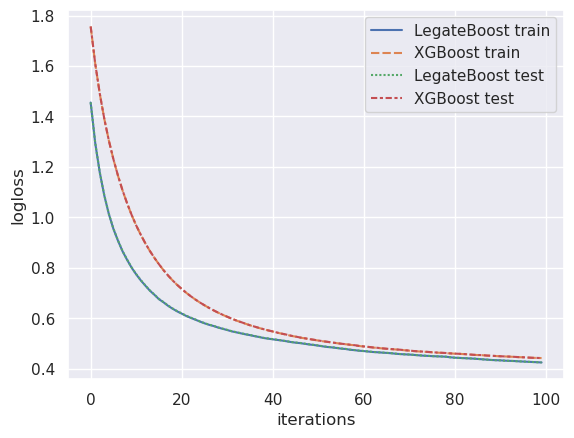

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
data = {"LegateBoost train": lb_metrics['train']['log_loss'], "XGBoost train": xgb_metrics['validation_0']['mlogloss'], "LegateBoost test": lb_metrics['eval-0']['log_loss'], "XGBoost test": xgb_metrics['validation_1']['mlogloss']}	
sns.lineplot(data=data)
plt.xlabel("iterations")
plt.ylabel("logloss")
